# CSC 8614 - Language Models
## CI3 - Parameter-Efficient Fine-Tuning with LoRA

This TP builds upon the GPT architecture we have previously explored. 

We will implement Low-Rank Adaptation (LoRA) from scratch and inject it into our pre-existing GPTModel.

Objectives:
- Implement the mathematical formulation of LoRA.
- Create a wrapper to convert standard Linear layers into LoRA-compatible layers.
- Inject these layers into a pre-trained GPT model.
- Verify that only a fraction of parameters are trainable.
- Fine-tune the model with LoRA

Some of this code comes from the book _Build a Large Language Model (From Scratch)_, by Sebastian Raschka, and its [official github repository](https://github.com/rasbt/LLMs-from-scratch).

This TP will be done in this notebook, and requires some additional files (available from the course website). 
You will have to fill the missing portions of code, and perform some additional experiments by testing different parameters.

Working on this TP:
- The easiest way is probably to work directly on the notebook, using jupyter notebook or visual studio code. An alternative is also to use Google colab.
- You should be able to run everything on your machine, but you can connect to the GPUs if needed.
- **NOTE**: run the cells in the correct order, otherwise you might get errors due to inconsintencies.

Some files are required, and are available on the course website and/or github repo:
- `requirements.txt`
- `gpt_utils.py`


## About the report
You will have to return this notebook (completed), as well as a mini-report (`TP3/rapport.md`).

The notebook and report shall be submitted via a GitHub repository, similarly to what you did for the previous sessions (remember to use a different folder: `TP3`).
For the notebook, it is sufficient to complete the code and submit the final version.

For the mini-report, you have to answer the questions asked in this notebook, and discuss some of your findings as requested.
Same as in the previous sessions:
- You must include: short answers, observed results (copies of outputs), requested screenshots, and a brief interpretation.
- Do not paste entire pages: be concise and select the relevant elements.

Reproducibility: 
- fix a random seed and write it in the report
- indicate in the report the specific python version OS, and the library versions.

## Prerequisite

Install the requirements.

**Note**: if you use the same virtual environment as last time, you will not have to reinstall everything.

In [2]:
# --- INSTRUCTOR CODE ---
!pip install -r requirements.txt

## Background & Mathematical Formulation

Fine-tuning Large Language Models (LLMs) updates all model parameters, which is computationally expensive. LoRA freezes the pre-trained weights and injects trainable rank decomposition matrices.

Given a pre-trained weight matrix $W_0 \in \mathbb{R}^{d_{out} \times d_{in}}$, LoRA constrains the update $\Delta W$ by representing it with a low-rank decomposition:

$$W_0 + \Delta W = W_0 + B A$$

Where:
- $B \in \mathbb{R}^{d_{out} \times r}$
- $A \in \mathbb{R}^{r \times d_{in}}$
- $r \ll \min(d_{in}, d_{out})$ is the rank.

The Forward Pass:

$$h = W_0 x + \frac{\alpha}{r} (B A x)$$

- $\alpha$ is a scaling constant.
- $A$ is initialized with random Gaussian values.
- $B$ is initialized with zeros (so training starts with no changes to the model).

## Setup

First, let's import the necessary libraries and our provided GPT utilities.

In [3]:
# --- INSTRUCTOR CODE ---
import torch
import torch.nn as nn
import math

from gpt_utils import GPTModel

2026-01-19 17:45:08.289451: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 17:45:08.342793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-19 17:45:09.900012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
RANDOM_STATE = 3333
torch.manual_seed(RANDOM_STATE)

## Implementing the LoRA Layer

In this exercise, you will create the LoRALayer module. This module computes the $\Delta Wx$ term (the branch on the right side of the diagram seen during the lecture).

### **Exercise 1**: Define the LoRA Module

Requirements:
1. Define dimensions for parameters A and B based on in_dim, out_dim, and rank.
2. Initialize A with kaiming_uniform_ (or small random normal).
3. Initialize B with zeros.
4. Implement the forward pass including the scaling factor $\frac{\alpha}{r}$.

In [5]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank # Scaling factor per LoRA paper
        
        self.A = nn.Parameter(torch.empty(rank, in_dim))
        self.B = nn.Parameter(torch.empty(out_dim, rank))
        
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)
        
    def forward(self, x):
        result = (x @ self.A.T @ self.B.T) * self.scaling
        return result

## Wrapping Linear Layers

We rarely replace the layer entirely; instead, we want a layer that holds both the frozen original weights and the new LoRA weights.

### **Exercise 2**: The LinearWithLoRA Wrapper

Requirements:
1. Store the original linear layer.
2. Create a self.lora instance using the dimensions of the original linear layer.
3. In forward, add the output of the original layer to the output of the LoRA layer.

In [6]:
class LinearWithLoRA(nn.Module):
    def __init__(self, linear_layer, rank, alpha):
        super().__init__()
        self.linear = linear_layer
        self.lora = LoRALayer(
            in_dim = linear_layer.in_features,
            out_dim = linear_layer.out_features,
            rank = rank,
            alpha = alpha
        )
        
    def forward(self, x):
        return self.linear(x) + self.lora(x)

# --- Sanity Check ---
# Create a dummy layer to test
input_x = torch.randn(1, 128)
original_layer = nn.Linear(128, 64)
lora_wrapped = LinearWithLoRA(original_layer, rank=4, alpha=8)

# Because B is initialized to zeros, the outputs should be identical initially
assert torch.allclose(original_layer(input_x), lora_wrapped(input_x))
print("Test Passed: Wrapper acts identically to original layer at initialization.")

Test Passed: Wrapper acts identically to original layer at initialization.


## Injecting LoRA into GPTModel

Now we need to modify our existing GPTModel. We cannot manually rewrite the class. Instead, we will iterate through the model's modules and replace specific layers dynamically.

In GPTModel, the transformer blocks are stored in *self.trf_blocks*. Inside those, we have attention mechanisms (att) containing W_query, W_key, W_value, or a combined c_attn.

Note: For this lab, to keep it simple, we will replace all nn.Linear layers except the final output head.

### **Exercise 3**: Recursive Model Modification

Requirements:
1. Iterate through named children of the model.
2. If a module is nn.Linear, wrap it in LinearWithLoRA.
3. Important: Skip the final output layer (often named out_head or similar in gpt_utils), as we usually don't want to reduce the rank of the vocabulary projection.

In [7]:
def replace_linear_with_lora(model, rank, alpha):
    """
    Recursively replaces nn.Linear with LinearWithLoRA.
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            if name == "lm_head":
                continue
            new_layer = LinearWithLoRA(module, rank, alpha)
            setattr(model, name, new_layer)
        else:
            # Recursive call for nested modules (like TransformerBlocks)
            replace_linear_with_lora(module, rank, alpha)

## Freeze & Verify

We have injected the layers, but currently, everything is still trainable. We must freeze the original weights.

### **Exercise 4**: Freezing and Counting Parameters
Requirements:
1. Set requires_grad = False for all parameters.
2. Iterate through the model; if a layer is LinearWithLoRA, unfreeze self.lora.A and self.lora.B.
3. Calculate the ratio of trainable parameters.

In [8]:
def freeze_and_activate_lora(model):
    for param in model.parameters():
        param.requires_grad = False

    for module in model.modules():
        if isinstance(module, LinearWithLoRA):
            module.lora.A.requires_grad = True
            module.lora.B.requires_grad = True

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            
    print(f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.2f}%")

## Putting it all together

Let's download and initialize the model from gpt_utils, then apply our LoRA transformation.

In [9]:
# --- INSTRUCTOR CODE ---
# (Basically same code as last session)

from gpt_utils import GPTModel, download_and_load_gpt2, load_weights_into_gpt

# Download the model weights (124M param version), and initialize it.
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2_weights")
print("Weights downloaded and loaded into memory.")

# Configure the model, mapping OpenAI specific keys to our model's keys (if needed)
model_config = {
    "vocab_size": settings["n_vocab"],
    "context_length": settings["n_ctx"],
    "emb_dim": settings["n_embd"],
    "n_heads": settings["n_head"],
    "n_layers": settings["n_layer"],
    "drop_rate": 0.1,
    "qkv_bias": True,
}

# Initialize the Base Model
model = GPTModel(model_config)
load_weights_into_gpt(model, params)


File already exists and is up-to-date: gpt2_weights/124M/checkpoint
File already exists and is up-to-date: gpt2_weights/124M/encoder.json
File already exists and is up-to-date: gpt2_weights/124M/hparams.json
File already exists and is up-to-date: gpt2_weights/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2_weights/124M/model.ckpt.index
File already exists and is up-to-date: gpt2_weights/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2_weights/124M/vocab.bpe
Weights downloaded and loaded into memory.


Now, we call all the methods we have defined above, and put everything together.

In [10]:
# --- INSTRUCTOR CODE ---

print("Original Model Structure (Truncated):")
print(model.trf_blocks[0]) # Print first block to see standard Linear layers

# Apply LoRA Replacement
# Rank 8, Alpha 16 (Alpha is usually set to 2x Rank as a rule of thumb)
replace_linear_with_lora(model, rank=8, alpha=16)

# 3. Freeze Weights
freeze_and_activate_lora(model)

# 4. Check Results
print("\nModel Structure After LoRA (Truncated):")
print(model.trf_blocks[0])

print("\nParameter Count:")
print_trainable_parameters(model)

Original Model Structure (Truncated):
TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=True)
    (W_key): Linear(in_features=768, out_features=768, bias=True)
    (W_value): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_resid): Dropout(p=0.1, inplace=False)
)

Model Structure After LoRA (Truncated):
TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): LinearWithLoRA(
      (linear): Linear(in_features=768, out_features=768, bias=True)
      (lora): LoRALayer()
    )
    (W_key): LinearWithLoRA(
      (linear): Linear(in_features=768, out_fea

**Question 1:** Do you see any difference between "Original Model Structure (Truncated)" and "Model Structure After LoRA (Truncated)"? Do you see the LinearWithLoRA you have defined above?

**Question 2:** What is the number of trainable parameters, all parameters, and the fraction of trainable parameters?

## Training Loop Verification

Finally, let's prove that gradients are only generated for the specific LoRA parameters.

In [11]:
# --- INSTRUCTOR CODE ---

# Create dummy input
batch_size = 2
dummy_input = torch.randint(0, 1000, (batch_size, 256))
dummy_target = torch.randint(0, 1000, (batch_size, 256))

# Optimizer setup
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3)

# Forward Pass
logits = model(dummy_input)
loss = torch.nn.functional.cross_entropy(logits.view(-1, model_config['vocab_size']), dummy_target.view(-1))

# Backward Pass
optimizer.zero_grad()
loss.backward()

# ---------------------------------------------------------
# Verification Step
# ---------------------------------------------------------
print("\nGradient Verification:")
grads_found = 0
grads_missing = 0

for name, param in model.named_parameters():
    if param.requires_grad:
        if param.grad is not None:
            grads_found += 1
        else:
            print(f"WARNING: Trainable parameter {name} has no gradient.")
    else:
        if param.grad is not None:
            print(f"ERROR: Frozen parameter {name} has a gradient!")
        else:
            grads_missing += 1

print(f"Parameters with gradients: {grads_found}")
print(f"Frozen parameters correctly without gradients: {grads_missing}")

if grads_found > 0 and grads_missing > 0:
    print("SUCCESS: Gradients are flowing correctly only into LoRA parameters.")


Gradient Verification:
Parameters with gradients: 146
Frozen parameters correctly without gradients: 197
SUCCESS: Gradients are flowing correctly only into LoRA parameters.


## SPAM Classification

Let's now work the Spam Classification task again, but this time using the LoRA-adapted model. 
This follows the example from the previous session.

### Download and prepare data

In [12]:
# --- INSTRUCTOR CODE ---

import urllib.request
import zipfile
import os
import pandas as pd

# Download the dataset
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = os.path.join(extracted_path, "SMSSpamCollection")

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset downloaded and extracted.")

# Load into DataFrame
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "text"])
print(f"Loaded {len(df)} examples.")
print(df.head())

# Class Balancing (primarily for speed in the lab)
spam_df = df[df["label"] == "spam"]
ham_df = df[df["label"] == "ham"].sample(len(spam_df), random_state=RANDOM_STATE)
df = pd.concat([spam_df, ham_df]).reset_index(drop=True)

# Map labels to integers
df["label"] = df["label"].map({"ham": 0, "spam": 1})
print(f"Balanced Dataset size: {len(df)}")

df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

print(f"Size of train_df: {len(train_df)}")
print(f"Size of test_df: {len(test_df)}")

print("Distribution of labels in the dataset:")
print("train:")
print(train_df['label'].value_counts())
print("test:")
print(test_df['label'].value_counts())


Loaded 5572 examples.
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Balanced Dataset size: 1494
Size of train_df: 1195
Size of test_df: 299
Distribution of labels in the dataset:
train:
label
1    600
0    595
Name: count, dtype: int64
test:
label
0    152
1    147
Name: count, dtype: int64


Define Dataset and DataLoader, similarly to previous session.

In [13]:
# --- INSTRUCTOR CODE ---

import tiktoken
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['text']
        label = row['label']
        
        # Tokenize
        encoded = self.tokenizer.encode(text, allowed_special={'<|endoftext|>'})
        
        # Truncate
        encoded = encoded[:self.max_length]
        
        # Pad (GPT-2 usually uses <|endoftext|> as padding)
        pad_len = self.max_length - len(encoded)
        encoded = encoded + [50256] * pad_len # 50256 is <|endoftext|> in GPT2
        
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Initialize Tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Create Loaders
train_loader = DataLoader(SpamDataset(train_df, tokenizer), batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(SpamDataset(test_df, tokenizer), batch_size=8, shuffle=False, drop_last=False)


We now modify the Model for Classification, replacing the final layer (out_head).

In [14]:
# --- INSTRUCTOR CODE ---

num_classes = 2

# Check input dimension of the current head
hidden_dim = model.out_head.linear.in_features

# Replace the head
model.out_head = nn.Linear(hidden_dim, num_classes)

# Move model to device (if using GPU, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("New Output Head:", model.out_head)

New Output Head: Linear(in_features=768, out_features=2, bias=True)


We previously froze everything except LoRA. Now we added a new head, let's make it unfrozen.

In [15]:
# --- INSTRUCTOR CODE ---

def set_classification_trainable(model):
    # Ensure LoRA layers are trainable (A and B)
    for module in model.modules():
        if isinstance(module, LinearWithLoRA):
            module.lora.A.requires_grad = True
            module.lora.B.requires_grad = True
    
    # Ensure the new classification head is trainable
    for param in model.out_head.parameters():
        param.requires_grad = True

set_classification_trainable(model)

# Verify count again
print_trainable_parameters(model)

trainable params: 1,328,642 || all params: 125,768,450 || trainable%: 1.06%


**Question 3:** Check the number (and fraction) of trainable parameters, and compare it with the one above. Do you see any differences? Can you describe them?

The Training Loop
Context: Standard PyTorch loop. Note that GPT models output [batch, seq_len, hidden]. For classification, we usually take the hidden state of the last token.

In [16]:
# --- INSTRUCTOR CODE ---

import time

def train_classifier(model, loader, optimizer, device, epochs=1):
    model.train()
    
    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # Forward Pass
            # The model outputs (batch, seq_len, num_classes)
            logits = model(inputs)
            
            # Select the last token for classification
            # last_token_logits = logits[:, -1, :]  
            # NOTE: this (the line above) was an error in the code provided with the previous lab: it was using the last token (which is most often PAD), 
            #   not the last non padding token. 
            # Select the last NON-PADDING token
            #   Create a mask (1 for real tokens, 0 for PAD); 50256 is the PAD token ID
            mask = (inputs != 50256)
            
            # Find the index of the last real token
            #    Summing the mask gives the length. Subtract 1 for 0-based index.
            #    .clamp(min=0) prevents errors if a sequence is empty (unlikely)
            last_idx = (mask.sum(dim=1) - 1).clamp(min=0)
            
            # Select the logits at those specific indices
            #    We use torch.arange for the batch dimension
            batch_indices = torch.arange(inputs.size(0), device=device)
            last_token_logits = logits[batch_indices, last_idx, :]
            
            loss = torch.nn.functional.cross_entropy(last_token_logits, targets)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate accuracy for monitoring
            preds = torch.argmax(last_token_logits, dim=-1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1} | Batch {batch_idx} | Loss: {loss.item():.4f}")

        acc = correct / total * 100
        print(f"Epoch {epoch+1} Finished | Avg Loss: {total_loss/len(loader):.4f} | Acc: {acc:.2f}% | Time: {time.time()-start_time:.2f}s")

In [17]:
# --- INSTRUCTOR CODE ---

# Setup Optimizer
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad], 
    lr=5e-4    # TODO: Potentially test with different learning rates
)

# Run Training
train_classifier(model, train_loader, optimizer, device, epochs=1)  # TODO: Potentially test with different numbers of epochs

Epoch 1 | Batch 0 | Loss: 1.7461
Epoch 1 | Batch 10 | Loss: 0.6633
Epoch 1 | Batch 20 | Loss: 0.1799
Epoch 1 | Batch 30 | Loss: 0.0338
Epoch 1 | Batch 40 | Loss: 0.0257
Epoch 1 | Batch 50 | Loss: 0.0072
Epoch 1 | Batch 60 | Loss: 0.0095
Epoch 1 | Batch 70 | Loss: 0.0044
Epoch 1 | Batch 80 | Loss: 0.0111
Epoch 1 | Batch 90 | Loss: 0.0199
Epoch 1 | Batch 100 | Loss: 0.0027
Epoch 1 | Batch 110 | Loss: 0.6705
Epoch 1 | Batch 120 | Loss: 0.0844
Epoch 1 | Batch 130 | Loss: 0.2230
Epoch 1 | Batch 140 | Loss: 0.0633
Epoch 1 Finished | Avg Loss: 0.2416 | Acc: 91.44% | Time: 32.78s


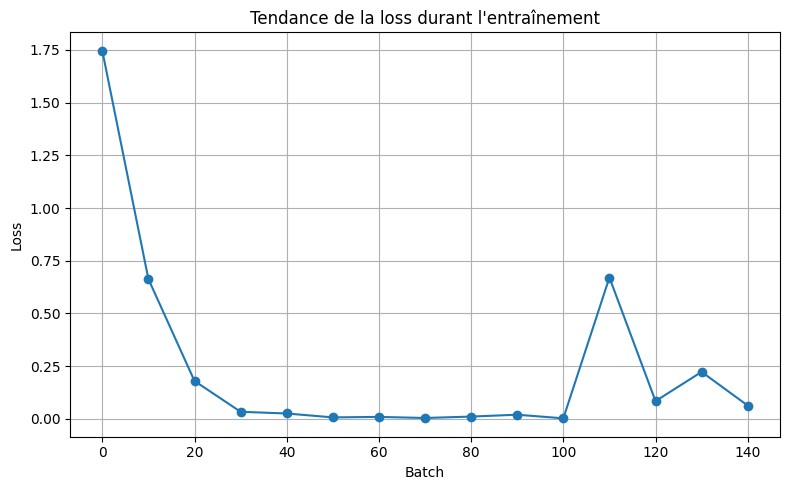

In [18]:
import matplotlib.pyplot as plt

# Batch indices and corresponding losses from the log
batches = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
losses = [1.7461,0.6633,0.1799,0.0338,0.0257,0.0072,0.0095,0.0044,0.0111,0.0199,0.0027,0.6705,0.0844,0.2230,0.0633]

plt.figure(figsize=(8,5))
plt.plot(batches, losses, marker='o')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Tendance de la loss durant l'entraînement")
plt.grid(True)
plt.tight_layout()

plt.savefig("training_loss_epoch1.png", dpi=300)


**Question 4:** Can you describe the trend of the loss, and the final accuracy. Is it reasonable considering the task at hand?

We can now test the accuracy on the held-out test set.

In [19]:
# --- INSTRUCTOR CODE ---

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            logits = model(inputs)
            
            # Select last "real" token logits
            mask = (inputs != 50256)
            last_idx = (mask.sum(dim=1) - 1).clamp(min=0)
            batch_idx = torch.arange(inputs.size(0), device=device)
            last_token_logits = logits[batch_idx, last_idx, :]
            # Select last token logits (same logic as training)
            # last_token_logits = logits[:, -1, :]
            
            # Get predictions
            predictions = torch.argmax(last_token_logits, dim=-1)
            
            # Compare with targets
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
            
    return correct / total

In [20]:
# --- INSTRUCTOR CODE ---

# Run evaluation
test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f"Test Set Accuracy: {test_accuracy*100:.2f}%")

Test Set Accuracy: 98.33%


**Question 5:** How is the accuracy, and how does it compare to the Train set accuracy?

Finally, we can do a quick inference test, to see how the model classifies new texts.

In [21]:
# --- INSTRUCTOR CODE ---

def classify_text(text, model, tokenizer, device):
    model.eval()
    
    # Preprocess
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded = encoded[:256] # Truncate
    tensor_input = torch.tensor([encoded], dtype=torch.long).to(device) # Add batch dim
    
    with torch.no_grad():
        logits = model(tensor_input)
        last_token_logits = logits[:, -1, :]
        probs = torch.softmax(last_token_logits, dim=-1)
        pred_label = torch.argmax(probs, dim=-1).item()
        
    label_map = {0: "HAM (Normal)", 1: "SPAM"}
    print(f"Text: '{text}'")
    print(f"Prediction: {label_map[pred_label]} (Confidence: {probs[0][pred_label]:.2f})")
    print("-" * 30)

In [22]:
# TODO: add the text you want to test.
classify_text("There is a big cash prize for you, call immediately.", model, tokenizer, device)
classify_text("Hey, are we still meeting for lunch tomorrow?", model, tokenizer, device)

Text: 'There is a big cash prize for you, call immediately.'
Prediction: SPAM (Confidence: 0.57)
------------------------------
Text: 'Hey, are we still meeting for lunch tomorrow?'
Prediction: HAM (Normal) (Confidence: 1.00)
------------------------------


---